In [106]:
import numpy as np
import matplotlib.pyplot as plt
import random

import Models.OWID as owid
import Models.SIRD as sird
import Models.GradientDescent as gd

#parameters are [A(0), I(0), gamma0, gamma1, nu, beta0, beta1, beta2, u(t) vars]
#consts are [dayNum, len(u(t))]

#A' = (b0 / (1 + (b1 * I)**(b2 * u(t)) ) )*A - gamma0*A
#I' = gamma1*A - nu*I


def startFunc(consts):
    
    #return ukVars
    params = np.zeros(8)
        
    params[0] = random.random()*.1 #A(0), between 0 and 10 percent of the population
    params[1] = random.random()*.001 #I(0), between 0 and .1 percent of the population
    
    params[2] = .5 + random.random()*.2 #gamma0, asympt->recovs + infected - floor asympt infect rate
    params[3] = .01 + random.random()*.1 #gamma1, asympt->infected

    params[4] = .001 + random.random()*.03 #nu, infected -> recov or dead

    params[5] = random.random() #beta0, ceiling infectRate - floor infect rate
    params[6] = 50 + 500*random.random() #beta2, scaler on feedback
    params[7] = .5 + random.random()*5 #beta3, exponential [.5, 5.5]
    
    return params
    
def simFunc(params, consts, giveA=False): #option to return A and I

    dayNum = consts[0]
    
    A = np.zeros((dayNum))
    I = np.zeros((dayNum))
    
    A[0] = params[0]
    I[0] = params[1]
    
    gamma0 = params[2]
    gamma1 = params[3]
    nu = params[4]
    
    beta = params[5:8]

    #iterate the arrays using the definition K' and I'
    for t in range(len(I)-1): #define I and K on range [1, length)
        diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]
        diffI = gamma1*A[t] - nu*I[t]
        
        A[t+1] = diffA + A[t]
        I[t+1] = diffI + I[t]

    if(giveA):
        return A,I
        
    return I #I is the data generated

def constrainFunc(parameters, consts):
    
    params = np.copy(parameters)

    #fill the constraints
    paramConstraints = np.zeros((len(params),2)) #min, max for each one
    
    paramConstraints[0] = [.0000000001, 1] #A(0)
    paramConstraints[1] = [ 0.000000001, 1] #I(0)

    paramConstraints[2] = [0.00001, 1] #gamma0
    paramConstraints[3] = [0.00001, 1] #gamma1
    
    paramConstraints[4] = [0.00001, 1] #nu

    paramConstraints[5] = [.1, 100] #beta1, beta1+beta2 ceiling
    paramConstraints[6] = [.1, 100000] #beta2, feedback scaling
    paramConstraints[7] = [.25, 10] #beta2
    
    for i in range(len(params)): #exercise each constraint
        params[i] = min( max(paramConstraints[i,0], params[i]) , paramConstraints[i,1])
    
    return params

def graphParams(params, consts):
    A, I = simFunc(params, consts, giveA=True)
    
    fig, ax = plt.subplots(figsize=(18,8))
    ax.plot(A, color="orange")
    ax.plot(I, color="red")
    return fig, ax

In [30]:
dates, I, R, D, V = owid.LoadCountryNormal("Italy") 

consts = [len(I), 0]

gradDesc = gd.GradDescent(I, consts, startFunc, simFunc, constrainFunc)

#gradDesc.eta = .001
#gradDesc.delta = .001


In [ ]:
bestError = 100
gradDesc.solveVars(printOut=100)


Startin Vars:
Error: 0.015725095470903384
[3.16342355e-02 7.50949262e-05 5.75565145e-02 2.73909938e-02
 4.97750226e-02 9.31975366e-02 5.22674654e+02 5.40538068e+00]


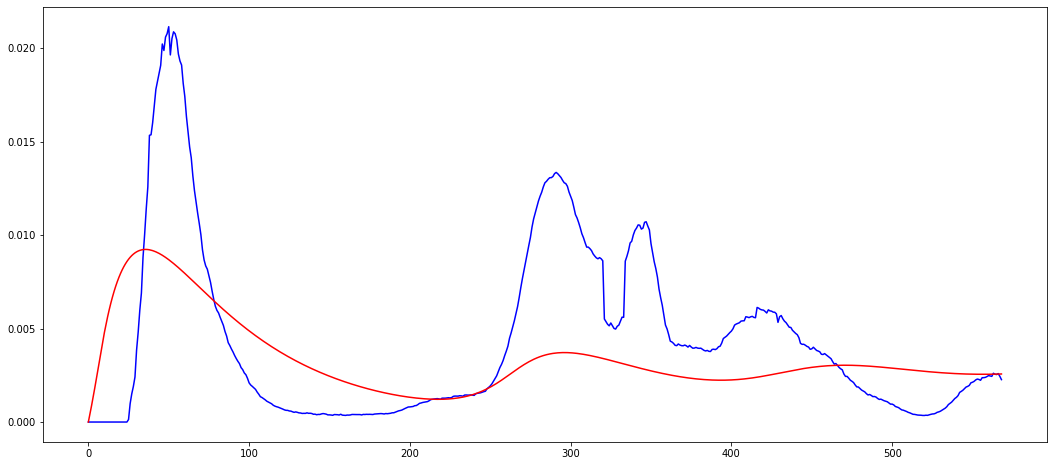

In [123]:
fig, ax = plt.subplots(figsize=(18,8))

gradDesc.x = gradDesc.simulate(gradDesc.params) 

ax.plot(gradDesc.y, color="blue")
ax.plot(gradDesc.x, color="red")